In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

import recova.learning_dataset
from recova.learning.learning import model_from_file
from recova.util import kullback_leibler, wishart_kl_divergence

np.set_printoptions(precision=3, linewidth=100)

In [11]:
DATASET_FILE = '/home/dlandry/dataset/learning_sets/2018-08-28-kitti-3-4-5.json'
LEARNING_RUN_FILE = '/home/dlandry/dataset/learning_runs/2018-08-29-kitti-03.json'
MODEL_FILE = '/home/dlandry/dataset/learning_runs/2018-08-29-kitti-03.model'
CENSI_ESTIMATES_FILE = '/home/dlandry/dataset/censi_estimates/2018-08-29-kitti-03.json'

In [12]:
with open(DATASET_FILE) as f:
    dataset = json.load(f)
    
with open(LEARNING_RUN_FILE) as f:
    learning_run = json.load(f)

with open(CENSI_ESTIMATES_FILE) as f:
    censi_estimates = json.load(f)
    
model = model_from_file(MODEL_FILE, 'cello')

In [13]:
xs = np.array(dataset['data']['xs'])
ys = np.array(dataset['data']['ys'])


train_set = learning_run['train_set']
validation_set = learning_run['validation_set']

In [14]:
validation_xs = xs[validation_set]
validation_ys = ys[validation_set]

train_ys = ys[train_set]
avg_train_ys = np.mean(train_ys, axis=0)

In [15]:
avg_train_ys

array([[ 4.318e-05,  2.405e-07,  4.569e-07,  1.847e-08, -1.103e-07,  1.692e-07],
       [ 2.405e-07,  1.514e-06, -3.310e-10,  1.975e-08, -6.806e-09, -2.784e-07],
       [ 4.569e-07, -3.310e-10,  3.536e-08, -8.761e-11, -2.384e-10,  3.669e-09],
       [ 1.847e-08,  1.975e-08, -8.761e-11,  1.280e-09, -1.464e-10, -4.190e-09],
       [-1.103e-07, -6.806e-09, -2.384e-10, -1.464e-10,  8.767e-10, -1.540e-09],
       [ 1.692e-07, -2.784e-07,  3.669e-09, -4.190e-09, -1.540e-09,  2.384e-07]])

In [16]:
predictions = model.predict(validation_xs)
censi_predictions = np.array(censi_estimates['data']['censi_estimates'])

In [17]:
reference_norms = np.zeros(len(predictions))
prediction_norms = np.zeros(len(predictions))
norm_loss = np.zeros(len(predictions))
wishart_kl = np.zeros(len(predictions))
gaussian_kl = np.zeros(len(predictions))
percent_loss = np.zeros(len(predictions))
censi_loss = np.zeros(len(predictions))
censi_kl = np.zeros(len(predictions))
baseline_loss = np.zeros(len(predictions))
baseline_kl = np.zeros(len(predictions))

for i in range(len(predictions)):
    reference_norms[i] = np.linalg.norm(ys[validation_set[i]])
    prediction_norms[i] = np.linalg.norm(predictions[i])
    wishart_kl[i] = wishart_kl_divergence(ys[validation_set[i]], 6, predictions[i], 6)
    norm_loss[i] = np.linalg.norm(ys[validation_set[i]] - predictions[i])
    percent_loss = abs(norm_loss[i] / np.linalg.norm(ys[validation_set[i]]))
    gaussian_kl[i] = kullback_leibler(ys[validation_set[i]], predictions[i])
    
    censi_loss[i] = np.linalg.norm(ys[validation_set[i]] - censi_predictions[i])
    censi_kl[i] = kullback_leibler(ys[validation_set[i]], censi_predictions[i])
    
    baseline_loss[i] = np.linalg.norm(ys[validation_set[i]] - avg_train_ys)
    baseline_kl[i] = kullback_leibler(ys[validation_set[i]], avg_train_ys)
    
    #print('{}: {}'.format(i, baseline_loss[i]))

/home/dlandry/repos/registration-covariance-analysis/recova/util.py:277: RuntimeWarning: invalid value encountered in log
  (scipy.special.multigammaln(prediction_degrees_of_freedom / 2., 6) - scipy.special.multigammaln(base_degress_of_freedom / 2., 6)) +
/home/dlandry/repos/registration-covariance-analysis/recova/util.py:277: RuntimeWarning: divide by zero encountered in log
  (scipy.special.multigammaln(prediction_degrees_of_freedom / 2., 6) - scipy.special.multigammaln(base_degress_of_freedom / 2., 6)) +


In [18]:
print('Dataset: {}'.format(learning_run['metadata']['cross_validation']))
print('N Pairs: {}'.format(len(predictions)))

print('Avg. Percent loss: {:.2E}'.format(percent_loss.mean()))
print()
#print('Avg. Wishart KL loss: {:.2E}'.format(wishart_kl.mean()))
print('Avg. Baseline loss: {:.4E}'.format(baseline_loss.mean()))
print('Avg. Baseline KL: {:.2f}'.format(baseline_kl.mean()))
print()
print('Avg. loss: {:.2E}'.format(norm_loss.mean()))
print('Avg. KL loss: {:.2f}'.format(gaussian_kl.mean()))
print()
print('Avg. Censi Loss: {:.2E}'.format(censi_loss.mean()))
print('Avg. Censi KL loss: {:.2f}'.format(censi_kl.mean()))
print()



Dataset: 03
N Pairs: 797
Avg. Percent loss: 1.59E+02

Avg. Baseline loss: 8.4480E-05
Avg. Baseline KL: 16.20

Avg. loss: 8.45E-05
Avg. KL loss: 16.20

Avg. Censi Loss: 4.65E-05
Avg. Censi KL loss: 16144.69



<IPython.core.display.Javascript object>


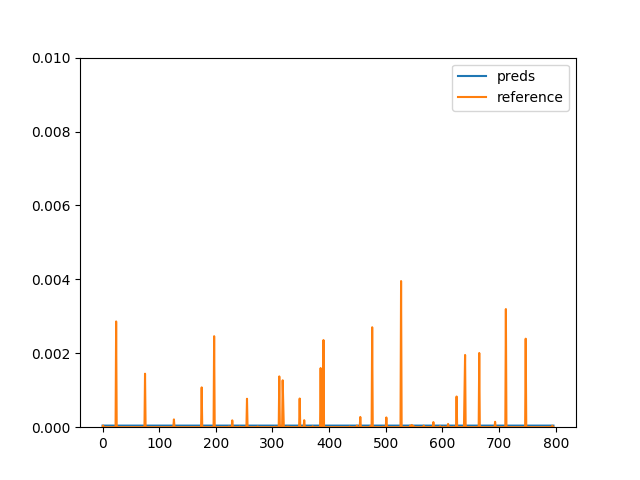

(0.0, 0.01)

In [19]:
plt.plot(list(range(len(predictions))), prediction_norms, label='preds')
plt.plot(list(range(len(predictions))), reference_norms, label='reference')
plt.legend()
ax = plt.gca()
#ax2 = ax.twinx()
ax.set_ylim([0.0, 0.01])

#ax2.plot(list(range(len(predictions))), gaussian_kl, color='red')
#plt.show()


In [30]:
gaussian_kl.max()

54.26043840607848

In [38]:
p = predictions[150]
ref = ys[validation_set[150]]

In [39]:
ref

array([[ 2.999e-07,  1.185e-08,  1.098e-08,  1.282e-09,  2.169e-09, -6.109e-09],
       [ 1.185e-08,  2.650e-08, -4.418e-09,  4.731e-10, -1.170e-09, -4.948e-10],
       [ 1.098e-08, -4.418e-09,  2.496e-08, -1.184e-09,  2.463e-09,  1.204e-10],
       [ 1.282e-09,  4.731e-10, -1.184e-09,  9.452e-10, -3.860e-10, -1.058e-10],
       [ 2.169e-09, -1.170e-09,  2.463e-09, -3.860e-10,  8.090e-10,  3.092e-11],
       [-6.109e-09, -4.948e-10,  1.204e-10, -1.058e-10,  3.092e-11,  4.659e-10]])

In [40]:
wishart_kl_divergence(ref, 6, p, 6)

49.27218534831394

In [41]:
p

array([[ 8.986e-05, -3.004e-07,  1.335e-06,  1.621e-08, -2.699e-07, -6.277e-07],
       [-3.004e-07,  2.725e-06,  5.143e-08,  4.375e-08,  1.904e-09, -5.640e-07],
       [ 1.335e-06,  5.143e-08,  1.037e-07,  8.898e-11, -7.000e-10, -4.506e-08],
       [ 1.621e-08,  4.375e-08,  8.898e-11,  5.720e-09, -2.598e-10, -1.616e-08],
       [-2.699e-07,  1.904e-09, -7.000e-10, -2.598e-10,  2.093e-09, -2.327e-11],
       [-6.277e-07, -5.640e-07, -4.506e-08, -1.616e-08, -2.327e-11,  5.336e-07]], dtype=float32)

In [42]:
ref

array([[ 2.999e-07,  1.185e-08,  1.098e-08,  1.282e-09,  2.169e-09, -6.109e-09],
       [ 1.185e-08,  2.650e-08, -4.418e-09,  4.731e-10, -1.170e-09, -4.948e-10],
       [ 1.098e-08, -4.418e-09,  2.496e-08, -1.184e-09,  2.463e-09,  1.204e-10],
       [ 1.282e-09,  4.731e-10, -1.184e-09,  9.452e-10, -3.860e-10, -1.058e-10],
       [ 2.169e-09, -1.170e-09,  2.463e-09, -3.860e-10,  8.090e-10,  3.092e-11],
       [-6.109e-09, -4.948e-10,  1.204e-10, -1.058e-10,  3.092e-11,  4.659e-10]])

In [43]:
p - ref

array([[ 8.956e-05, -3.123e-07,  1.324e-06,  1.493e-08, -2.720e-07, -6.216e-07],
       [-3.123e-07,  2.699e-06,  5.585e-08,  4.328e-08,  3.074e-09, -5.635e-07],
       [ 1.324e-06,  5.585e-08,  7.872e-08,  1.273e-09, -3.163e-09, -4.518e-08],
       [ 1.493e-08,  4.328e-08,  1.273e-09,  4.775e-09,  1.262e-10, -1.606e-08],
       [-2.720e-07,  3.074e-09, -3.163e-09,  1.262e-10,  1.284e-09, -5.419e-11],
       [-6.216e-07, -5.635e-07, -4.518e-08, -1.606e-08, -5.419e-11,  5.331e-07]])

array([[ 2.986e+02, -2.636e+01,  1.206e+02,  1.165e+01, -1.254e+02,  1.017e+02],
       [-2.636e+01,  1.019e+02, -1.264e+01,  9.146e+01, -2.627e+00,  1.139e+03],
       [ 1.206e+02, -1.264e+01,  3.153e+00, -1.075e+00, -1.284e+00, -3.752e+02],
       [ 1.165e+01,  9.146e+01, -1.075e+00,  5.052e+00, -3.269e-01,  1.518e+02],
       [-1.254e+02, -2.627e+00, -1.284e+00, -3.269e-01,  1.587e+00, -1.753e+00],
       [ 1.017e+02,  1.139e+03, -3.752e+02,  1.518e+02, -1.753e+00,  1.144e+03]])